## Get the data

In [4]:
import pandas as pd

df = pd.read_csv("../cleaned_dataset.csv")
df

,Unnamed: 0,Year,Month,Day,Dew Point Temp.,Mean Temperature,Max Temperature,Min Temperature,Mean Cloud,Mean Pressure,...,Total Sunlight,Wind Speed,Day of Year,SO2,NOX,NO2,CO,RSP,O3,FSP
0,0,1991,4,1,9.4,15.4,19.3,12.1,57.0,1025.1,...,7.1,7.851941,91,42.0,218.0,70.0,147.0,56.0,33.0,37.0
1,1,1991,4,2,10.8,16.6,19.1,14.9,79.0,1025.8,...,3.4,9.920213,92,48.0,269.0,99.0,154.0,56.0,36.0,37.0
2,2,1991,4,3,11.6,17.5,19.8,15.8,53.0,1023.0,...,8.8,10.066439,93,41.0,242.0,98.0,124.0,54.0,37.0,35.0
3,3,1991,4,4,14.6,18.5,21.4,16.5,89.0,1018.7,...,1.3,9.610053,94,45.0,271.0,98.0,132.0,45.0,25.0,30.0
4,4,1991,4,5,17.1,19.7,21.0,18.8,90.0,1014.7,...,1.8,11.099544,95,32.0,221.0,89.0,112.0,38.0,23.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157,12157,2024,10,27,22.0,27.3,29.2,25.9,77.0,1009.3,...,3.3,12.200000,301,3.0,75.0,49.0,49.0,24.0,30.0,18.0
12158,12158,2024,10,28,19.2,25.8,27.2,24.6,83.0,1010.1,...,0.3,9.700000,302,3.0,100.0,53.0,60.0,16.0,28.0,11.0
12159,12159,2024,10,29,19.1,25.3,26.7,23.7,86.0,1011.1,...,1.7,8.400000,303,3.0,104.0,61.0,56.0,19.0,31.0,14.0
12160,12160,2024,10,30,18.7,26.2,29.3,24.3,70.0,1010.3,...,7.8,8.300000,304,4.0,136.0,77.0,60.0,28.0,36.0,20.0


In [5]:
from sklearn.model_selection import train_test_split

tem_train, tem_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

## Modeling

c:\Users\vince\anaconda3\envs\gp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MSE: 0.059400165740965606
Test R²: 0.997


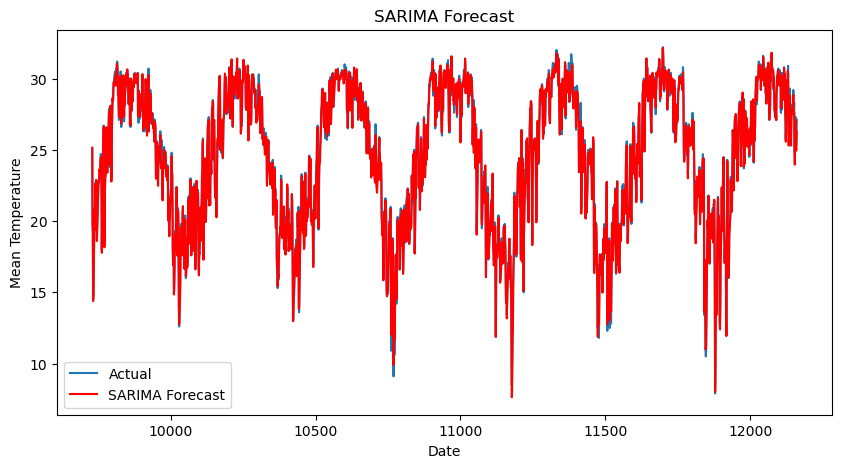

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the SARIMA model parameters
order = (1, 0, 0)  # Non-seasonal order (p, d, q)
seasonal_order = (2, 1, 1, 12)  # Seasonal order (P, D, Q, S)

# Fit the SARIMA model
sarima_model = SARIMAX(endog=tem_train['Mean Temperature'], exog=tem_train[['Mean Cloud','Mean Pressure','Rainfall','Relative Humidity','Wet Bulb Temp.','Evaporation','Global Solar Radiation','Max UV','Mean UV','Prevailing Wind Direction','Total Sunlight','Wind Speed','Day of Year','SO2','NOX','NO2','CO','RSP','O3','FSP']],
                       order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Make predictions
sarima_pred_m = sarima_model_fit.predict(start=tem_test.index[0], end=tem_test.index[-1],
                                            exog=tem_test[['Mean Cloud','Mean Pressure','Rainfall','Relative Humidity','Wet Bulb Temp.','Evaporation','Global Solar Radiation','Max UV','Mean UV','Prevailing Wind Direction','Total Sunlight','Wind Speed','Day of Year','SO2','NOX','NO2','CO','RSP','O3','FSP']])

# Calculate error
mse = mean_squared_error(tem_test['Mean Temperature'], sarima_pred_m)
r2 = r2_score(tem_test['Mean Temperature'], sarima_pred_m)
print('Test MSE:', mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(tem_test.index, tem_test['Mean Temperature'], label='Actual')
plt.plot(tem_test.index, sarima_pred_m, color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

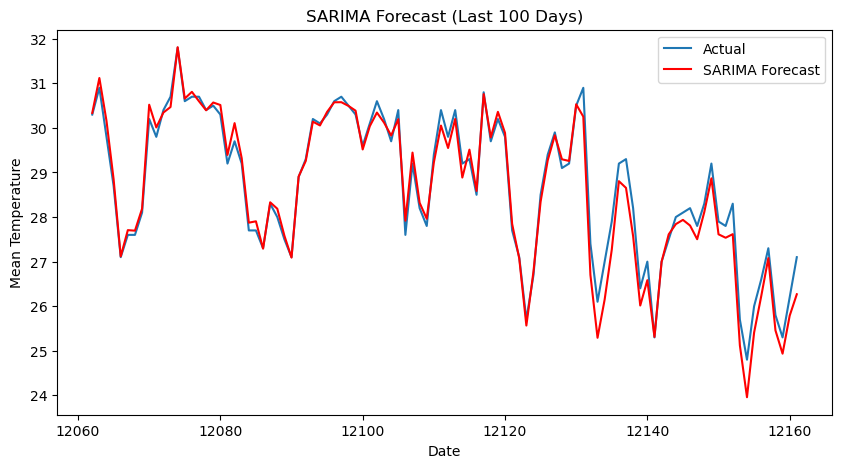

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(tem_test.tail(100).index, tem_test.tail(100)['Mean Temperature'], label='Actual')
plt.plot(tem_test.tail(100).index, sarima_pred_m.tail(100), color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('SARIMA Forecast (Last 100 Days)')
plt.legend()
plt.show()
